# Predicción de la demanda de taxis en aeropuertos para optimizar la disponibilidad de conductores

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Se construirá un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.
Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Pasos a realizar en el proyecto.

1. Descargar los datos y hacer el remuestreo por una hora.
2. Analizar los datos
3. Entrenar diferentes modelos con diferentes hiperparámetros. La muestra de prueba sera  del 10% del conjunto de datos inicial.
4. Probar los datos usando la muestra de prueba.



Se importan las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

### Funciones

In [42]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Crea nuevas características de calendario y calcula valores de desfase y media móvil para una tabla de datos.
    Parámetros:
    - data (DataFrame): Tabla de datos que contiene la serie temporal.
    - max_lag (int): Número máximo de desfases a calcular.
    - rolling_mean_size (int): Tamaño de la ventana para el cálculo de la media móvil.

    Retorna:
    None. Modifica la tabla de datos "data" añadiendo las nuevas características.

    Funcionalidad:
    Esta función agrega cuatro nuevas características de calendario a la tabla de datos:
    - "year": Año de la fecha en la columna de índice.
    - "month": Mes de la fecha en la columna de índice.
    - "day": Día del mes de la fecha en la columna de índice.
    - "dayofweek": Día de la semana de la fecha en la columna de índice.

    Además, calcula los valores de desfase (lag) de la columna "num_orders" hasta un máximo de "max_lag" desfases.
    Cada desfase se agrega como una nueva característica con el formato "lag_X", donde X representa el número de desfase.

    Por último, calcula la media móvil de la columna "num_orders" utilizando una ventana de tamaño "rolling_mean_size".
    El resultado se agrega como una nueva característica llamada "rolling_mean".

    Ejemplo de uso:
    >>> make_features(data, max_lag=7, rolling_mean_size=3)

    Consideraciones:
    - La columna de índice de la tabla de datos debe ser de tipo "datetime" para que las características de calendario se calculen correctamente.
    - Los valores de "max_lag" y "rolling_mean_size" deben ser enteros positivos.
    """
    # Se añaden características de calendario
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    # Se calcula valores de desfase 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Se calcula la media móvil
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

## Análisis

A continuación, se procede a leer el archivo CSV que contiene la información de los pedidos de taxis y se almacena en la variable 'df'. Posteriormente, se llevará a cabo un análisis exploratorio y estadístico con el objetivo de obtener una visión general de los datos y detectar posibles valores anómalos.

In [2]:
# Informacion general del dataframe
df = pd.read_csv("D:\\PROYECTOS\\datasets\\taxi.csv", index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# se imprimen las  primeras filas
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Tenemos un DataFrame que contiene 26,496 registros correspondientes a pedidos de taxis registrados.
Al momento del leer el archivo CSV, se convirtiendo una serie temporal, utilizando la primera columna como índice y convirtiéndola en formato date time, ya que contenía datos sobre fechas y horas, de ese modo convertir los datos a un formato conveniente para realizar el analisis y los modelos de predicción.

El DataFrame consta de dos columnas:

- datetime: Esta columna contiene información sobre la fecha y hora de cada registro, incluyendo el día, mes, año y se proporciona en intervalos de 10 minutos.

- num_orders: Esta columna registra el número de pedidos de taxis realizados durante cada intervalo de 10 minutos.

Debido a que la información sobre las fechas está dada por minutos, se procedera a realizar un remuestreo cambiando el intervalo de las series a una hora.

In [4]:
# se ordena el DataFrame según los índices en orden ascendente
df.sort_index(inplace=True)

# Resamplear el DataFrame agrupando los datos en intervalos de 1 hora y sumar los valores dentro de cada intervalo
df = df.resample('1H').sum()

# se imprimen las primeras filas del DataFrame resultante
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Se obtuvo un DataFrame que contiene la información del número de pedidos de taxis por hora.

In [27]:
# se buscan valores ausentes 
print('Numero de valores ausentes en el datframe:')
print('')
df.isnull().sum()

Numero de valores ausentes en el datframe:



num_orders    0
dtype: int64

Estadísticas descriptivas del DataFrame:
                     num_orders
Recuento                4416.00
Media                     84.42
Desviación estándar       45.02
Mínimo                     0.00
Cuartil 1                 54.00
Mediana                   78.00
Cuartil 3                107.00
Percentil 90             143.00
Percentil 95             166.00
Percentil 99             223.00
Máximo                   462.00


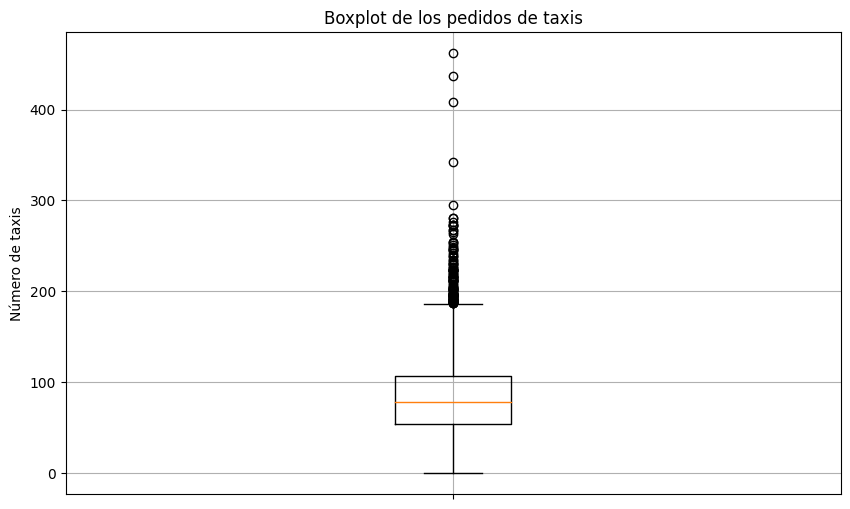

In [21]:
# Obtener estadísticas descriptivas del DataFrame
statistics = df.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

# Personalizar el formato de los valores
statistics = statistics.apply(lambda x: round(x, 2))

# Renombrar el índice "50%" a "Mediana"
statistics = statistics.rename(index={"50%": "Mediana"})

# Agregar título
statistics = statistics.rename(index={"count": "Recuento", 
                                      "mean": "Media", 
                                      "std": "Desviación estándar", 
                                      "min": "Mínimo", 
                                      "25%": "Cuartil 1", 
                                      "50%": "Mediana", "75%": 
                                      "Cuartil 3", "90%": "Percentil 90", 
                                      "95%": "Percentil 95", 
                                      "99%": "Percentil 99", 
                                      "max": "Máximo"})

# Imprimir estadísticas descriptivas
print('Estadísticas descriptivas del DataFrame:')
print(statistics)

# boxplot de los datos estadisticos
plt.figure(figsize=(10, 6))
plt.boxplot(df['num_orders'])
plt.title('Boxplot de los pedidos de taxis')
plt.ylabel('Número de taxis')
plt.xticks([1], [''])
plt.grid(True)
plt.show()

En promedio, se registran aproximadamente 84.42 pedidos de taxis por hora, con una desviación estándar de alrededor de 45.02. Esto indica una variabilidad en los datos, lo que sugiere que la demanda de taxis puede fluctuar significativamente en diferentes momentos del día.

Algunas horas no se realizaron pedidos de taxis, como lo indica el valor mínimo de 0. Además, se observa que el 25% de las horas registraron 54 pedidos de taxis o menos, mientras que el 50% de las horas tuvieron 78 pedidos de taxis o menos, y el 75% de las horas registraron 107 pedidos de taxis o menos.

Al analizar los percentiles más altos, podemos observar que el 90% de las horas tuvieron 143 pedidos de taxis o menos, el 95% de las horas tuvieron 166 pedidos de taxis o menos, y el 99% de las horas registraron 223 pedidos de taxis o menos. Estos valores destacan que la mayoría de las horas tienen una demanda moderada de taxis.

El valor máximo observado es de 462 pedidos de taxis en una hora, lo que indica que en ciertos momentos se registra una demanda significativamente alta.

Se creara un gráfico que permita analizar y comprender la tendencia general de los pedidos de taxis en los aeropuertos.

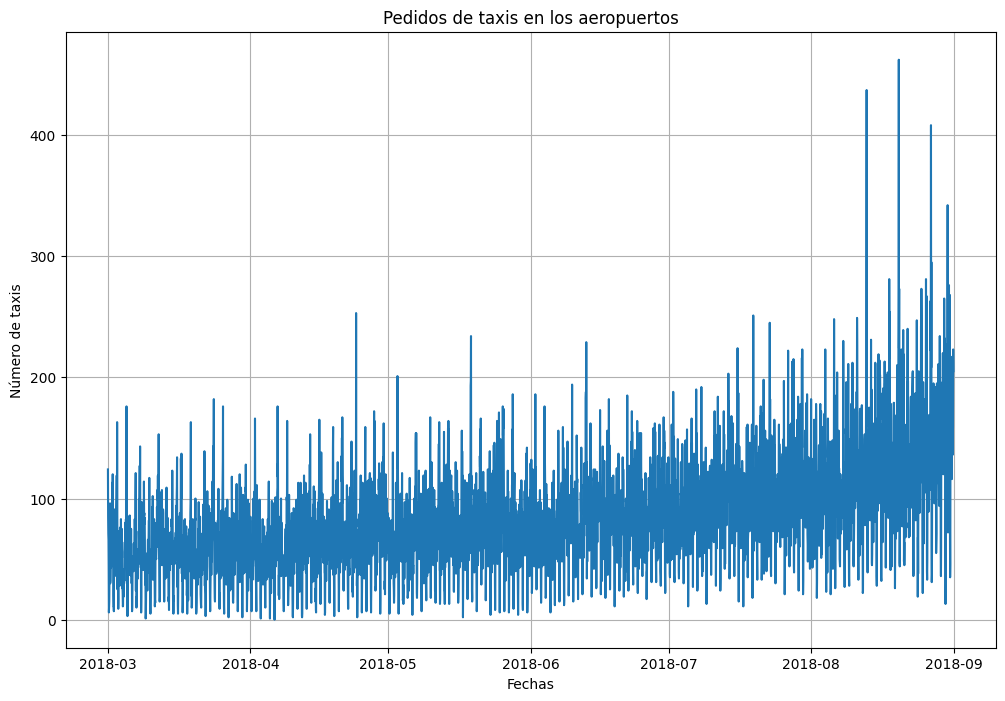

In [7]:
# grafico de los pedidios de taxis por mes
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['num_orders'])
plt.title('Pedidos de taxis en los aeropuertos')
plt.xlabel('Fechas')
plt.ylabel('Número de taxis')
plt.grid(True)
plt.show()

El gráfico inicial representa los pedidos de taxis por mes, pero presenta dificultades en su legibilidad debido a la gran cantidad de puntos de datos en un solo gráfico. Esto hace complicado identificar patrones o tendencias claras en la demanda de taxis. Para abordar este problema, se  realizará un remuestreo de los datos a intervalos diarios y obtener la suma total de pedidos de taxis por día. Esto permitirá una visualización más clara de la demanda a lo largo del tiempo.

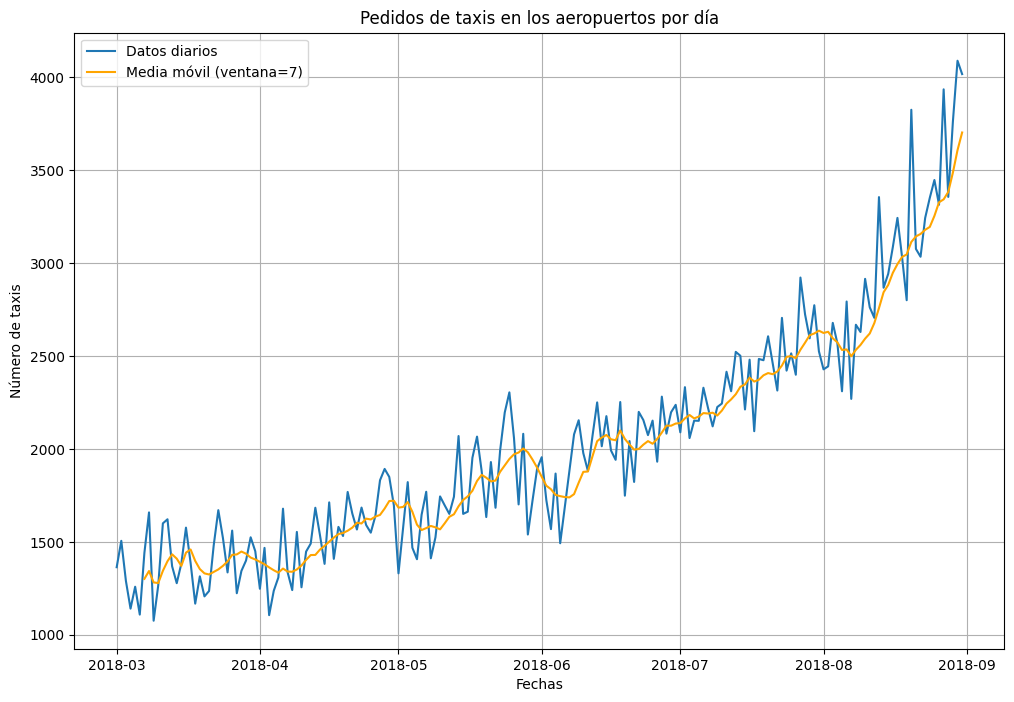

In [29]:
# grafico de los datos por dia 
df_daily = df.resample('1D').sum()


# Calculo de la media móvil con ventana de 2
rolling_mean = df_daily['num_orders'].rolling(window=7).mean()

plt.figure(figsize=(12, 8))
plt.plot(df_daily.index, df_daily['num_orders'], label='Datos diarios')
plt.plot(df_daily.index, rolling_mean, color='orange', label='Media móvil (ventana=7)')
plt.title('Pedidos de taxis en los aeropuertos por día')
plt.xlabel('Fechas')
plt.ylabel('Número de taxis')
plt.grid(True)
plt.legend()
plt.show()

Al modificar el intervalo para mostrar los datos diarios, se pueden observar las fluctuaciones diarias en la demanda de taxis. Se pueden identificar picos ascendentes en ciertos momentos, lo cual sugiere períodos de alta demanda. Estos picos podrían estar vinculados a eventos especiales, horas pico u otras situaciones particulares que generan una mayor necesidad de servicios de taxi. Además, es notable una tendencia generalmente creciente a partir del mes de abril.

Para proporcionar una representación suavizada de la tendencia, se ha agregado al gráfico una media móvil para ayudar a suavizar las variaciones diarias y resaltar la tendencia a largo plazo de los pedidos de taxis.

### Tendencias y estacionalidad

Con el objetivo de obtener una comprensión más profunda de la serie temporal, se llevará a cabo un análisis de la tendencia y la estacionalidad de los datos. Se examinarán tanto en el conjunto de datos completo como en períodos más cortos. En particular, se realizará un análisis a nivel horario. Además, se focalizará en un intervalo de fechas específicas, comprendido entre '2018-03-01' y '2018-03-30', para un estudio más detallado de la tendencia y estacionalidad en ese período.

**Tendencia y estacionalidad del conjunto de datos completo**

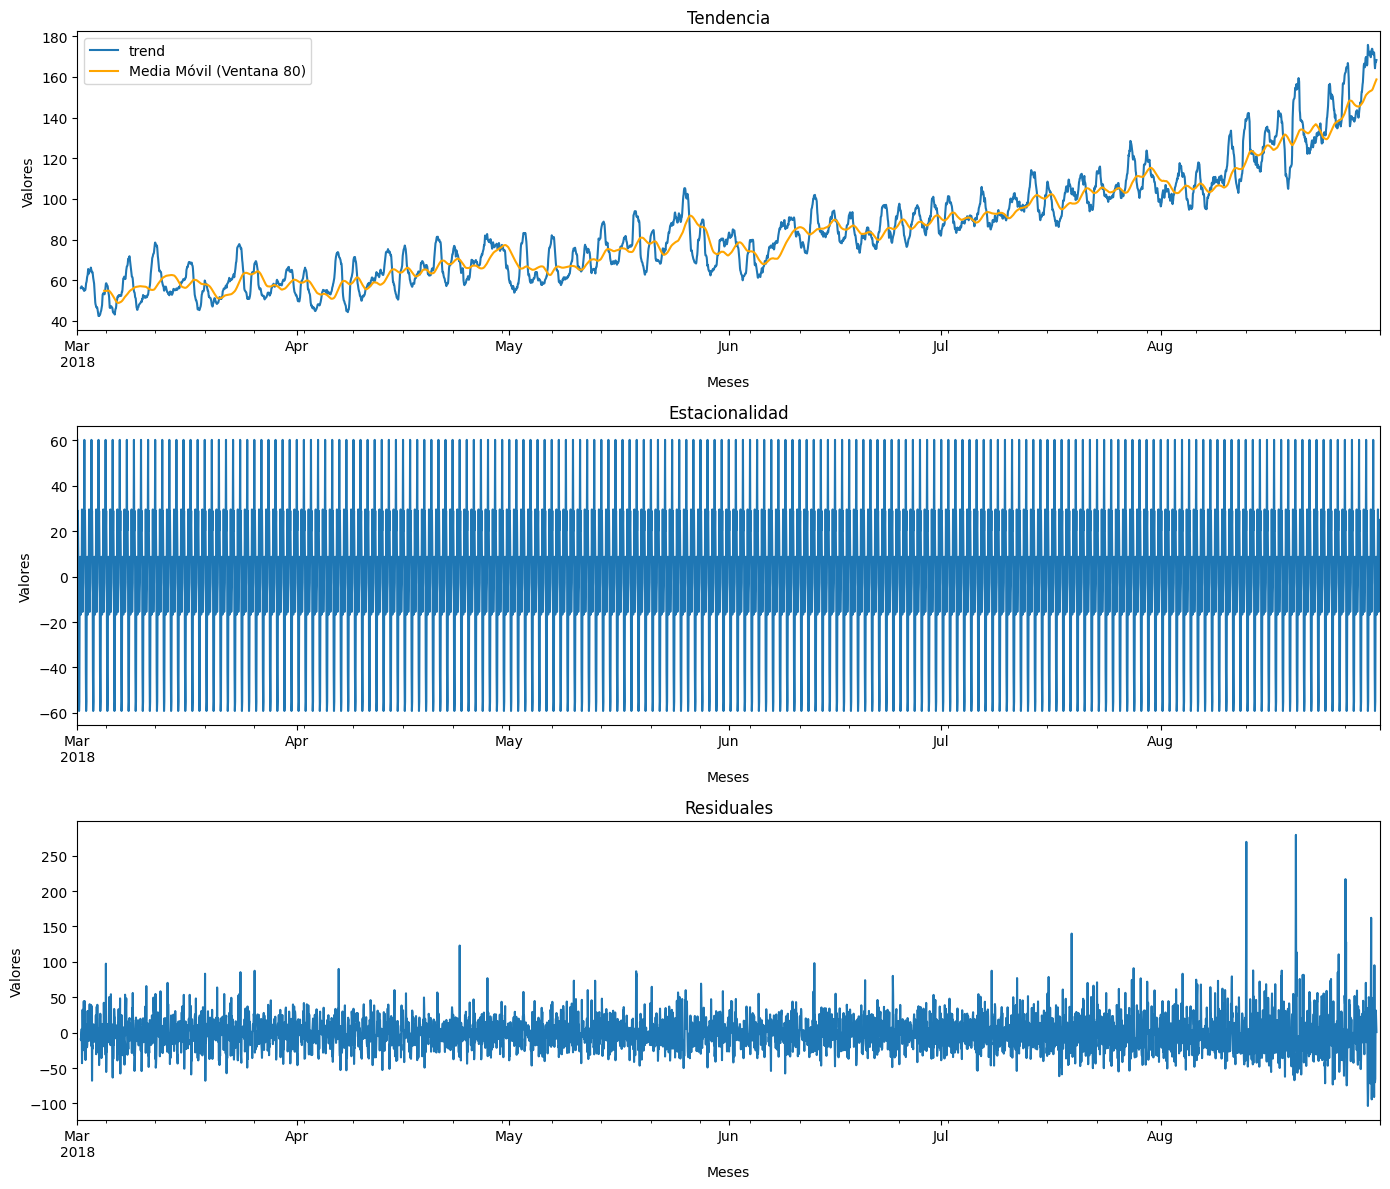

In [41]:
# Descomposición de la serie temporal utilizando la función seasonal_decompose()
decomposed = seasonal_decompose(df)

# Creación de los gráficos
plt.figure(figsize=(14, 12))

# Gráfico de la tendencia
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.rolling(window=80).mean().plot(ax=plt.gca(), color='orange', label='Media Móvil (Ventana 80)')
plt.title('Tendencia')
plt.xlabel('Meses')
plt.ylabel('Valores')
plt.legend()

# Gráfico de la estacionalidad
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Meses')
plt.ylabel('Valores')

# Gráfico de los residuales
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.xlabel('Meses')
plt.ylabel('Valores')

# Se ajusta el espaciado entre los subplots
plt.tight_layout()

Después de un análisis exhaustivo, se ha observado un incremento continuo en los pedidos de taxis a lo largo de los meses, con un aumento notable a partir del mes de mayo. Sin embargo, debido a la gran cantidad de datos disponibles, la estacionalidad tiene un periodo de menos de un mes, por lo que veremos mas de cerca en el siguiente grafico.

**Tendencia y estacionalidada en un período de 30 días**

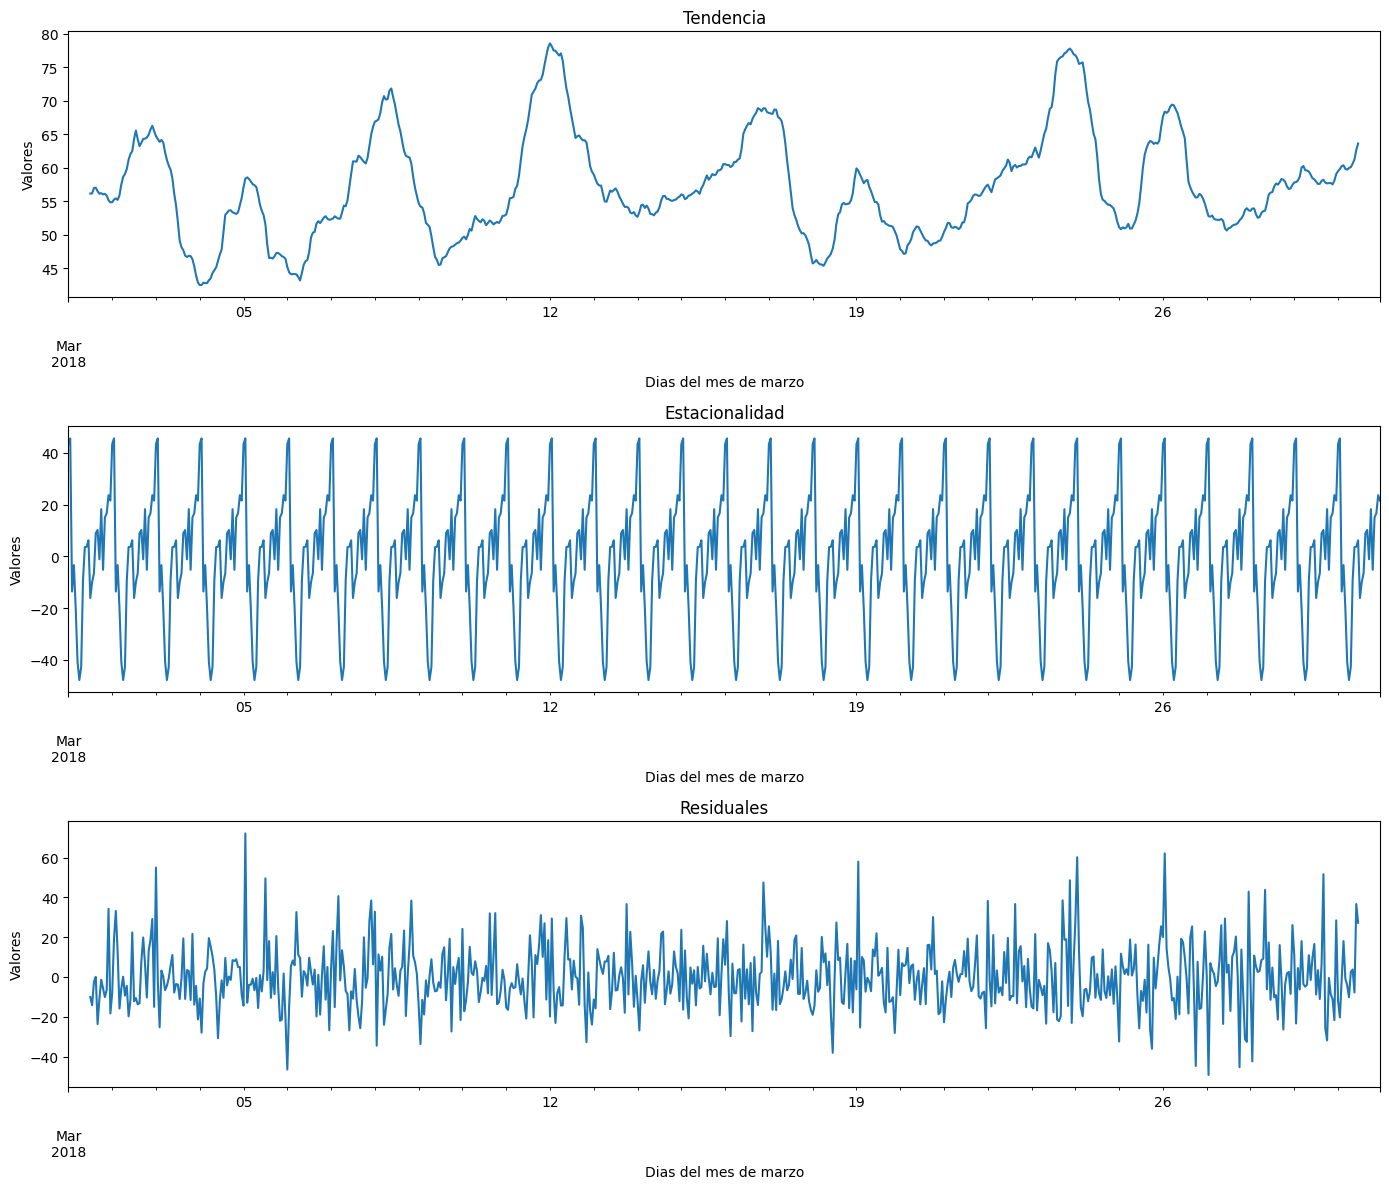

In [33]:

# resampleados en intervalos de 1 hora y sumando los valores dentro de cada intervalo
df_short = df['2018-03-01':'2018-03-30'].resample('1H').sum()

# Descomposición de la serie temporal "df_short" utilizando la función seasonal_decompose()
decomposed = seasonal_decompose(df_short)

# Creación de  los gráficos
plt.figure(figsize=(14, 12))

# Gráfico de la tendencia
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.xlabel('Dias del mes de marzo')
plt.ylabel('Valores')

# Gráfico de la estacionalidad
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Dias del mes de marzo')
plt.ylabel('Valores')

# Gráfico de los residuales
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.xlabel('Dias del mes de marzo')
plt.ylabel('Valores')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

**Conclusión**

Al reducir la cantidad de información mostrada en los gráficos, se han eliminado los valores atípicos que podrían tener un impacto desproporcionado en la serie temporal, así como los cambios repentinos. Como resultado, ahora se puede apreciar con mayor claridad una tendencia claramente ascendente a partir de los primeros 10 días del mes de marzo. En el gráfico anterior, parecía que el incremento se iniciaba a partir del mes de abril, lo cual no reflejaba con precisión la realidad. Además, al observar el patrón estacional, se puede notar que el consumo de pedidos de taxis tiende a ser menor durante las mañanas.

## Enriquecimiento de los datos

El objetivo principal de este proyecto es desarrollar un modelo que pueda predecir los valores futuros de los pedidos de taxis para la próxima hora. Para lograrlo, se aplicará una función al dataframe existente con el fin de crear nuevas características. Esta función agregará cuatro características de calendario adicionales a la tabla, las cuales incluyen el año, el mes, el día y el día de la semana. Además, se calcularán los valores de desfase y se incorporará la media móvil como otra característica relevante para el modelo. Estas transformaciones en el dataframe nos permitirán tener un conjunto de datos más enriquecido y apropiado para realizar las predicciones deseadas.

Se aplicara la función 'make_features' al dataframe con un maximo de 6 desfases y una ventana de 10 para el cálculo de la media móvil.

In [43]:
# Se aplica la función make_features 
make_features(df, 6, 10)

Se dividen los datos en conjuntos de entrenamiento y prueba.

In [45]:
# Segmentación de los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(df, shuffle=False, test_size=0.25) 

# Eliminación de filas con valores NaN en el conjunto de entrenamiento
train.dropna(inplace=True)

# Se imprime el rango de fechas del conjunto de entrenamiento y prueba
print("Rango de fechas del conjunto de entrenamiento:")
print("Desde", train.index.min(), "hasta", train.index.max())
print('-'*50)
print("Rango de fechas del conjunto de prueba:")
print("Desde", test.index.min(), "hasta", test.index.max())

Rango de fechas del conjunto de entrenamiento:
Desde 2018-03-01 10:00:00 hasta 2018-07-16 23:00:00
--------------------------------------------------
Rango de fechas del conjunto de prueba:
Desde 2018-07-17 00:00:00 hasta 2018-08-31 23:00:00


Separación de características y variable objetivo en el conjunto de entrenamiento y prueba

In [46]:
# División de los datos en características y objetivo para el conjunto de entrenamiento
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

# División de los datos en características y objetivo para el conjunto de prueba
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# se imprimen las primeras filas  de las caracteristicas de entrenamiento
features_train.head()

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 10:00:00,2018,3,1,3,69.0,34.0,15.0,12.0,6.0,43.0,52.5
2018-03-01 11:00:00,2018,3,1,3,64.0,69.0,34.0,15.0,12.0,6.0,46.5
2018-03-01 12:00:00,2018,3,1,3,96.0,64.0,69.0,34.0,15.0,12.0,47.6
2018-03-01 13:00:00,2018,3,1,3,30.0,96.0,64.0,69.0,34.0,15.0,43.5
2018-03-01 14:00:00,2018,3,1,3,32.0,30.0,96.0,64.0,69.0,34.0,40.1


## Prueba de Modelos de Regresión

Con el objetivo de seleccionar el mejor modelo para realizar las predicciones, se llevará a cabo una comparación de diversos modelos de regresión, incluyendo:

- LinearRegression
- Lasso
- RandomForestRegressor
- DecisionTreeRegressor
- LGBMRegressor

Se llevará a cabo la búsqueda de los mejores hiperparámetros para cada modelo. Esto implica explorar diferentes combinaciones de valores para los hiperparámetros y seleccionar aquellos que optimicen el rendimiento del modelo.

Posteriormente, se evaluarán las predicciones generadas por cada uno de estos modelos utilizando la métrica RMSE. Esto permitirá determinar cuál de ellos presenta un rendimiento más favorable.

### Linear Regression 

In [47]:
# creacion del modelo de regresion lineal
lr_model = LinearRegression()

# entrenamiento del modelo
lr_model.fit(features_train, target_train)

# predicciones en el conjunto de entrenamiento y  prueba 
pred_train_lr = lr_model.predict(features_train)
pred_test_lr = lr_model.predict(features_test)

### Lasso

In [48]:
# creacion del modelo lasso
lss_model = Lasso(alpha=0.1)

# entrenamiento del modelo
lss_model.fit(features_train, target_train)

# predicciones en el conjunto de entrenamiento y  prueba 
pred_train_lss = lss_model.predict(features_train)
pred_test_lss = lss_model.predict(features_test)

### Random Forest Regressor

In [49]:
# diccionario con los parámetros a explorar para Bosque aleatorio
rf_parameter_space = {"n_estimators": [100,200],
                      "max_depth" : [4,6,8,10],
                      "min_samples_split": [2,4,6],
                      "max_features":[ 0.3,0.6,1.0],
                      'min_samples_leaf': [2,3,4]
                     }

rf_model = RandomForestRegressor()
cv_random_state = 100

# búsqueda aleatoria de hiperparámetros y ajuste del modelo
rf_rscv = RandomizedSearchCV(rf_model, rf_parameter_space, random_state=cv_random_state, n_iter=5, n_jobs=-1)
rf_rscv.fit(features_train, target_train)
print('Los mejores parametros para el modelo de bosque aleatorio son:', rf_rscv.best_params_)

Los mejores parametros para el modelo de bosque aleatorio son: {'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 10}


In [50]:
# aplicacion del modelo de bosque aleatorio con los mejores hiperparametros
rf_model= RandomForestRegressor(random_state=cv_random_state,
                                min_samples_split=6,
                                max_features=0.3,
                                n_estimators=200,
                                max_depth=10,
                                min_samples_leaf=2)
# ajuste del modelo
rf_model.fit(features_train, target_train)

# predicciones en el conjunto de entrenamiento y  prueba 
pred_train_rf = rf_model.predict(features_train)
pred_test_rf = rf_model.predict(features_test)

### Decision Tree Regressor

In [51]:
# diccionario con los parámetros a explorar para arbol de decisiones
grid_dt = {'max_depth': [2,4,6,8,10],
           'min_samples_split':[2,4],
          'min_samples_leaf': [1,2,3]}

model_dt = DecisionTreeRegressor()

# búsqueda  de hiperparámetros y ajuste del modelo
dt_grid = GridSearchCV(model_dt,param_grid=grid_dt)
dt_grid.fit(features_train, target_train)
print('Los mejores parametros para el modelo de bosque aleatorio son:', dt_grid.best_params_)

Los mejores parametros para el modelo de bosque aleatorio son: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [52]:
# aplicacion del modelo de arbol de decisiones con los mejores hiperparametros
model_dt = RandomForestRegressor(random_state=100,max_depth=4, min_samples_leaf=3,min_samples_split=2)
# ajuste del modelo
model_dt.fit(features_train, target_train)

# predicciones en el conjunto de entrenamiento y  prueba 
pred_train_dt = model_dt.predict(features_train)
pred_test_dt = model_dt.predict(features_test)

### LightGBM

In [53]:
# diccionario con los parámetros a explorar para lgbm
lgbm_params = {
    'bagging_fraction': (0.5, 0.6, 0.9),
    'feature_fraction': (0.2, 0.5),
    'max_depth': (5,7, 10,12),
    'num_leaves': (40,50,60),
    'min_data_in_leaf':(100,200)
}
# búsqueda aleatoria de hiperparámetros y ajuste del modelo
lgbm_tuned_model = RandomizedSearchCV(estimator=lgbm.LGBMRegressor(), param_distributions=lgbm_params,random_state=100)
lgbm_tuned_model.fit(features_train, target_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] b

RandomizedSearchCV(estimator=LGBMRegressor(),
                   param_distributions={'bagging_fraction': (0.5, 0.6, 0.9),
                                        'feature_fraction': (0.2, 0.5),
                                        'max_depth': (5, 7, 10, 12),
                                        'min_data_in_leaf': (100, 200),
                                        'num_leaves': (40, 50, 60)},
                   random_state=100)

In [54]:
print('Los mejores parametros para el modelo de bosque aleatorio son:', lgbm_tuned_model.best_params_)


Los mejores parametros para el modelo de bosque aleatorio son: {'num_leaves': 60, 'min_data_in_leaf': 100, 'max_depth': 7, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


In [55]:
# aplicacion del modelo lgbm  con los mejores hiperparametros
lgbm_model = lgbm.LGBMRegressor(num_leaves = 60,
                                feature_fraction=0.5,
                                max_depth=7,
                                bagging_fraction =0.5,
                                min_data_in_leaf=100,
                                boosting_type = "goss",
                                objective= "regression")
# ajuste del modelo
lgbm_model.fit(features_train, target_train)

# predicciones en el conjunto de entrenamiento y  prueba 
pred_train_lgbm = lgbm_model.predict(features_train)
pred_test_lgbm = lgbm_model.predict(features_test)

## Evaluación del rendimiento de los modelos

In [56]:
print('RECM para el conjunto de entrenamiento con Regresion lineal:', mean_squared_error(target_train, pred_train_lr) **0.5)
print('RECM para el conjunto de prueba con Regresion Lineal:', mean_squared_error(target_test, pred_test_lr) **0.5)

print('------------------------------------------------------------------------------------------------------------')

print('RECM para el conjunto de entrenamiento con Lasso:', mean_squared_error(target_train, pred_train_lss) **0.5)
print('RECM para el conjunto de prueba con Lasso:', mean_squared_error(target_test, pred_test_lss) **0.5)

print('------------------------------------------------------------------------------------------------------------')


print('RECM para el conjunto de entrenamiento con Bosque aleatorio:', mean_squared_error(target_train, pred_train_rf) **0.5)
print('RECM para el conjunto de prueba con Bosque aleatorio:', mean_squared_error(target_test, pred_test_rf) **0.5)

print('-----------------------------------------------------------------------------------------------------------')


print('RECM para el conjunto de entrenamiento con Arbol de decisiones:', mean_squared_error(target_train, pred_train_dt) **0.5)
print('RECM para el conjunto de prueba con Arbol de decisiones:', mean_squared_error(target_test, pred_test_dt) **0.5)


print('-----------------------------------------------------------------------------------------------------------')

print('RECM para el conjunto de entrenamiento con Lgbm:', mean_squared_error(target_train, pred_train_lgbm) **0.5)
print('RECM para el conjunto de prueba con Lgbm:', mean_squared_error(target_test, pred_test_lgbm) **0.5)





RECM para el conjunto de entrenamiento con Regresion lineal: 28.498374251038673
RECM para el conjunto de prueba con Regresion Lineal: 46.134898382700754
------------------------------------------------------------------------------------------------------------
RECM para el conjunto de entrenamiento con Lasso: 28.498637455673478
RECM para el conjunto de prueba con Lasso: 46.15619928536733
------------------------------------------------------------------------------------------------------------
RECM para el conjunto de entrenamiento con Bosque aleatorio: 20.712754026384108
RECM para el conjunto de prueba con Bosque aleatorio: 53.204418737670515
-----------------------------------------------------------------------------------------------------------
RECM para el conjunto de entrenamiento con Arbol de decisiones: 27.094842994093412
RECM para el conjunto de prueba con Arbol de decisiones: 54.19992266259561
--------------------------------------------------------------------------------

Aunque el modelo de Bosque Aleatorio muestra un rendimiento superior en el conjunto de entrenamiento, su desempeño en el conjunto de prueba no es tan satisfactorio. Por otro lado, el modelo de Regresión Lineal, a pesar de tener un rendimiento inferior en el conjunto de entrenamiento en comparación con el Bosque Aleatorio, logra obtener mejores resultados en el conjunto de prueba. Por lo tanto, basándonos en la evaluación en el conjunto de prueba, el modelo de Regresión Lineal se considera el mejor modelo para realizar las predicciones en este conjunto de datos.

# Conclusión

Tras realizar el análisis de la serie temporal, se llevaron a cabo diversas acciones para preparar los datos. Se convirtió la primera columna en un índice de formato date time y se remuestrearon los datos a un intervalo de una hora para facilitar el análisis.

Durante el análisis exploratorio, se determinó que no había valores atípicos que pudieran afectar los resultados. Se examinaron las tendencias y estacionalidad de la serie temporal, revelando una tendencia creciente en los pedidos de taxis en los aeropuertos a partir de los primeros días del mes de marzo. También se observó un patrón estacional, donde el consumo de pedidos de taxis tiende a ser menor en las mañanas todos los días.

Además, se enriqueció el conjunto de datos creando nuevas características basadas en las fechas y se segmentaron los datos en conjuntos de entrenamiento y prueba para probar diferentes modelos.

Se evaluaron varios modelos y se calculó la métrica RECM para cada uno de ellos. Aunque los modelos LGBM y Bosque Aleatorio mostraron un mejor rendimiento en el conjunto de entrenamiento, al realizar las predicciones y evaluarlas en el conjunto de prueba, el modelo de regresión lineal obtuvo la mejor puntuación en la métrica RECM.

En conclusión, el modelo de regresión lineal demostró ser el más adecuado para realizar predicciones en este conjunto de datos. A pesar de que otros modelos tuvieron un mejor desempeño en el entrenamiento, el modelo de regresión lineal logró generalizar mejor y fue más preciso al predecir los valores futuros de los pedidos de taxis.

